# TME 2 : Prédiction de gènes - Détection de gènes candidats

Le but de ce TME est d’annoter les régions dans le génome qui correspondent à des gènes. Nous allons prendre en compte les différents éléments qui définissent un gène pour pouvoir déterminer les candidats à des régions codantes : phases ouvertes de lecture, propriétés statistiques du code génétique, et comparer les résultats avec l’annotation qui est disponible. 
Nous nous baserons sur le génome de _Bifidobacterium actinocoloniiforme_ que nous avons commencé à analyser au TME précédent, avec ses annotations et au génome de _Escherichia coli_


**Nom etudiant 1 : LI Junji**

**Nom etudiant 2 : BABAALI Mohamed**

### A) Mise en route,  télécharger et preparer les données

<b>Question 1)</b> Adapter les commandes du TME précédent pour télécharger le génome de _E. coli_ ainsi que ses annotations


ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/026/345/GCF_000026345.1_ASM2634v1/GCF_000026345.1_ASM2634v1_genomic.fna.gz

ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/026/345/GCF_000026345.1_ASM2634v1/GCF_000026345.1_ASM2634v1_feature_table.txt.gz


In [3]:
import urllib.request
#Utliser la fonction urllib.request.urlretrieve(path)

In [4]:
#download _genomic.fna.gz
urllib.request.urlretrieve("ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/026/345/GCF_000026345.1_ASM2634v1/GCF_000026345.1_ASM2634v1_genomic.fna.gz", "_genomic.fna.gz")

('_genomic.fna.gz', <email.message.Message at 0x7fd2ead01790>)

In [5]:
#download _feature_table.txt.gz
urllib.request.urlretrieve("ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/026/345/GCF_000026345.1_ASM2634v1/GCF_000026345.1_ASM2634v1_feature_table.txt.gz", "_feature_table.txt.gz")


('_feature_table.txt.gz', <email.message.Message at 0x7fd3003b9a60>)

<b>Question 2)</b> Decompresser les fichiers

In [6]:
import gzip
import shutil

In [7]:
#Decompresser _genomic.fna.gz
with gzip.open('_genomic.fna.gz', 'rb') as f_in:
    with open('GCF_000026345.1_ASM2634v1_genomic.fna', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [8]:
#Decompresser _feature_table.txt.gz
with gzip.open('_feature_table.txt.gz', 'rb') as f_in:
    with open('_feature_table.txt', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

<b>Question 3)</b> Exécuter le code ci-dessous qui va créer un dictionnaire pour représenter le code genetique. Vous avez également deux jeu de séquences pour tester les prochaines fonctions.

In [9]:
# Dictionnaire codons -> acides aminés. Les codons stops sont représentés
# avec le caractère "*"
CODEGENETIQUE = {
    "TTT": "F", "TTC": "F","TTA": "L","TTG": "L","TCT": "S","TCC": "S","TCA": "S","TCG": "S","TAT": "Y","TAC": "Y",
    "TAA": "*","TAG": "*","TGT": "C","TGC": "C","TGA": "*","TGG": "W","CTT": "L","CTC": "L","CTA": "L","CTG": "L",
    "CCT": "P","CCC": "P","CCA": "P","CCG": "P","CAT": "H","CAC": "H","CAA": "Q","CAG": "Q","CGT": "R","CGC": "R",
    "CGA": "R","CGG": "R","ATT": "I","ATC": "I","ATA": "I","ATG": "M","ACT": "T","ACC": "T","ACA": "T","ACG": "T",
    "AAT": "N","AAC": "N","AAA": "K","AAG": "K","AGT": "S","AGC": "S","AGA": "R","AGG": "R","GTT": "V","GTC": "V",
    "GTA": "V","GTG": "V","GCT": "A","GCC": "A","GCA": "A","GCG": "A","GAT": "D","GAC": "D","GAA": "E","GAG": "E",
    "GGT": "G","GGC": "G","GGA": "G","GGG": "G"
}

# Utiliser les sequences TESTSEQ et TESTSEQCLEAN pour tester vos fonctions
TESTSEQ = "ATGAAACGCATTAGCMMCACCATTACCACCACCATCACCATTACCACAGKTAACGGTGCGGGCTGA"
TESTSEQCLEAN = "ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGA"

### B) Annotation des phases ouvertes de lecture et traduction en séquence protéique

<b>Question 1)</b> Parfois dans les génomes (représentés par des fichiers numériques), nous trouvons des nucléotides qui n'ont pas été correctement identifiés par la machine de séquençage. Certains instruments nous restreignent les possibilités à un sous-ensemble de nucléotides. Ecrire une fonction `remplace_non_identifies` qui remplace les nucléotides non identifiés par une des possibilités listées ci-dessous de façon aléatoire.<br>

R = G,A (purine)<br>
Y = T,C (pyrimidine)<br>
K = G,T (céto)<br>
M = A,C (amino)<br>
S = G,C (obligations solides)<br>
W = A,T (Les liaisons faibles)<br>
B = G,T,C (tous sauf A)<br>
D = G,A,T (tous sauf C)<br>
H = A,C,T (tous sauf G)<br>
V = G,C,A (tous sauf T)<br>
N = A,G,C,T (any)<br>
X = A,G,C,T (any)<br>



In [10]:
import doctest # C’est pour pouvoir utiliser doctest.testmod() et tester les fonctions
import random

In [11]:
random.choice(['A', 'C', 'T', 'G'])

'C'

In [12]:
def remplace_non_identifies(seq):
    """
    Remplace les nucléotides non identifiés par une des possibilités de façon aléatoire.
    entrée : sequence ayant peut-etre des nucleotides non identifiés
    sortie : sequence (nettoyé) sans nucléotides non identifiés 
    >>> remplace_non_identifies(TESTSEQCLEAN)
    'ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGA'
    """
    options = {
        "R": ["G", "A"],
        "Y": ["T", "C"],
        "K": ["G", "T"],
        "M": ["A", "C"],
        "S": ["G", "C"],
        "W": ["A", "T"],
        "B": ["G", "T", "C"],
        "D": ["G", "A", "T"],
        "H": ["A", "C", "T"],
        "V": ["G", "C", "A"],
        "N": ["A", "G", "C", "T"],
        "X": ["A", "G", "C", "T"]
    }
    res = ""
    for index in range(len(seq)):
        if seq[index] in options:
            res += random.choice(options[seq[index]])
        else:
            res += seq[index]
    return res

doctest.testmod()

remplace_non_identifies(TESTSEQ)

'ATGAAACGCATTAGCAACACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGA'

<b>Question 2)</b> Ecrire une fonction `listecodon` qui renvoie une liste de codons pour une séquence passée en paramètre. Par exemple, si on passe la séquence ``AACGTGGCA`` comme paramètre votre fonction doit renvoyer ``[‘AAC’, ‘GTG’, ‘GCA’]``. Si la longueur de la séquence n'est pas un multiple de 3 on ne tiendra pas compte des 1 ou 2 nucléotides restant à la fin.


In [13]:
#Pour avoir une aide sur la documentation de python
?range

Init signature: range(self, /, *args, **kwargs)
Docstring:     
range(stop) -> range object
range(start, stop[, step]) -> range object

Return an object that produces a sequence of integers from start (inclusive)
to stop (exclusive) by step.  range(i, j) produces i, i+1, i+2, ..., j-1.
start defaults to 0, and stop is omitted!  range(4) produces 0, 1, 2, 3.
These are exactly the valid indices for a list of 4 elements.
When step is given, it specifies the increment (or decrement).
Type:           type
Subclasses:     


In [14]:
# Question 2
def listecodon(seq):
    """
    Renvoie une liste de codons pour une séquence passée en paramètre.
    entrée : sequence de nucléotides
    sortie : list de codons de la sequence d'entrée

    Si la longueur de la séquence n'est pas un multiple de 3 elle ne tiendra pas 
    compte des 1 ou 2 nucléotides restant à la fin.
    
    >>> listecodon('AAACCC')
    ['AAA', 'CCC']
    >>> listecodon('AAACC')
    ['AAA']
    >>> listecodon('AAAC')
    ['AAA']
    """
    
    seq3x = seq[:(len(seq)//3)*3]
    return [seq3x[i:i+3] for i in range(0, len(seq3x), 3)]

doctest.testmod()

assert listecodon(TESTSEQCLEAN) == [
    'ATG', 'AAA', 'CGC', 'ATT', 'AGC', 'ACC', 'ACC', 'ATT', 'ACC', 'ACC',
    'ACC', 'ATC', 'ACC', 'ATT', 'ACC', 'ACA', 'GGT', 'AAC', 'GGT', 'GCG',
    'GGC', 'TGA']

<b>Question 3)</b> Ecrire une fonction `reversecompl` qui renvoie le brin complémentaire d’une séquence passée en paramètre. Par exemple, si on passe la séquence ``AACGTGGCA`` comme paramètre votre fonction doit renvoyer ``TGCCACGTT``.


In [43]:
# Question 3
def reversecompl(seq):
    """Renvoie le brin complémentaire d’une séquence.
    entrée : sequence de nucléotides (brin sens)
    sortie : sequence de nucléotides (brin complementaire)
    >>> reversecompl('AACGTGGCA')
    'TGCCACGTT'
    """
    compl = {'A': 'T', 'C': 'G', 'G': 'C', 'T':'A'}
    res = ''
    for index in range(len(seq)):
        res += compl[seq[index]]
    return res[::-1]

print (reversecompl('AACGTGGCA'))
assert reversecompl(TESTSEQCLEAN) == "TCAGCCCGCACCGTTACCTGTGGTAATGGTGATGGTGGTGGTAATGGTGGTGCTAATGCGTTTCAT"

TGCCACGTT


<b>Question 4-a)</b> Ecrire une fonction `trouve_positions_orfs` qui etant donnée une liste de codon retourne les positions (start, stop) de cadre ouverts de la liste des codons, c'est à dire la séquence commençant par un des codons start: ``ATG``, ``GTG``, ``TTG`` (``ATG`` est le plus fréquent) et finissant par un des codons stop : ``TAA``, ``TAG``, ``TGA``.

Note : si plusieurs start sont trouvés dans la liste de codons, l'orf débute par conventions au start le plus en amont. <br>


In [16]:
def trouver_positions_orfs(codons):
    """Retourne les positions de cadre ouverts de la liste des codons.
    entrée : liste de codons
    sortie : les positions [start] et [stop] de cadre ouverts de la liste des codons
    
    >>> trouver_positions_orfs(['ATG', 'AAA', 'CGC', 'ATT', 'TAG', 'ATG', 'ACC', 'ATT', 'ACC', 'ACC', 'ACC', 'ATC', 'ACC', 'ATT', 'ACC', 'ACA', 'GGT', 'AAC', 'TGA', 'GGT', 'GCG', 'GGC'])
    ([0, 5], [4, 18])
    """
    starts = [i for i, codon in enumerate(codons) if codon in {'ATG', 'GTG', 'TTG'}] #positions de tous les starts dans codons
    stops =  [i for i, codon in enumerate(codons) if codon in {'TAA', 'TAG', 'TGA'}] #positions de tous les stops  dans codons
    
   
    orf_starts = [] #renvoie la liste de positions de codons start
    orf_stops = []  #renvoie la liste de positions de codons stop, les deux liste ont la meme taille et sont de pair start/stop 
    
    if len(starts)== 0 or len(stops) == 0:
        return (orf_starts, orf_stops)
    
    starts_index = stops_index = last_starts_index = last_stops_index = 0
    
    orf_starts.append(starts[starts_index])

    count_append = 1
    
    while starts_index < len(starts) and stops_index < len(stops):
        if count_append%2 == 0: # append start
            starts_index += 1
            if starts_index >= len(starts):
                break
            if(starts[starts_index] > stops[last_stops_index]):
                orf_starts.append(starts[starts_index])
                last_starts_index = starts_index
                count_append += 1
            
        else: # count_append//2 == 1, append stop
            if(stops[stops_index] > starts[last_starts_index]):
                orf_stops.append(stops[stops_index])
                last_stops_index = stops_index
                count_append += 1
            stops_index += 1
    
    if count_append%2 == 1:
        orf_starts.pop()

    return (orf_starts, orf_stops)

# doctest.testmod()

<b>Question 4-b)</b> Ecrire une fonction `liste_orfs` qui retourne la liste de tous les cadres ouverts de lectures, c'est à dire les séquence commençant par un des codons start: ``ATG``, ``GTG``, ``TTG`` (``ATG`` est le plus fréquent) et finissant par un des codons stop : ``TAA``, ``TAG``, ``TGA``. Vous renverrez les séquences pour les 6 phases de lecture (3 pour le brin sens et 3 pour le brin complémentaire). Ces séquences sont nommées séquences CDS (pour _CoDing Sequences_ en anglais) et les phases ouvertes de lecture ORFS (pour _Open Reading Frame_). <br>

**Note 1**: Coder d'abord la fonction `liste_orfs_sens` qui retourne la liste de trois cadres ouverts de lectures du brin sens. Pour retourver la liste de trois cadres ouverts de lectures du brin complementaire, vous pouvez combiner les deux fonctions `reversecompl` et `liste_orfs_sens`

**Note 2**: Vous pouvez utiliser les fonctions precedents tels que `listecodon` et `trouver_position_orfs`




In [17]:
# Question 4



def liste_orfs_sens(seq):
    """
    Liste de tous les cadres ouverts de lectures du brin sens.
    entrée : sequence de nucléotides 
    sortie : liste contenant tous les cadres ouverts de lectures
    >>> sorted(liste_orfs_sens('AAATGATGTAATAGTGTTTTGATTAGGGCAT'))
    ['ATGATGTAA', 'GTGTTTTGA']
    """
    orfs = []
    cadres = [listecodon(seq), listecodon(seq[1:]), listecodon(seq[2:])]
    for i_cadre in range(3):
        (start_liste, stop_liste) = trouver_positions_orfs(cadres[i_cadre])
        assert(len(start_liste) == len(stop_liste))
        for index in range(len(start_liste)):
            start_pos = start_liste[index]
            stop_pos = stop_liste[index]
            orfs.append(''.join(cadres[i_cadre][start_pos:stop_pos+1]))
    return orfs


sorted(liste_orfs_sens('AAATGATGTAATAGTGTTTTGATTAGGGCAT'))


def liste_orfs(seq):
    """
    Liste de tous les cadres ouverts de lectures du brin sens et complementaire.
    entrée : sequence de nucléotides 
    sortie : liste contenant tous les cadres ouverts de lectures      
    >>> sorted(liste_orfs('AAATGATGTAATAAGTTTTGATTAGGGTA'))
    ['ATGATGTAA']
    >>> sorted(liste_orfs('AAATGATGTAATAGTGTTTTGATTAGGGCAT'))
    ['ATGATGTAA', 'ATGCCCTAA', 'GTGTTTTGA']
    """
    return liste_orfs_sens(seq) + liste_orfs_sens(reversecompl(seq))

doctest.testmod()

TestResults(failed=0, attempted=9)

In [18]:
liste_orfs(TESTSEQCLEAN)

['ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGA']

Voici un code efficaz qui utilise Regular Expression

In [19]:
import re

In [20]:
[
    match.group()
    for match in re.finditer('((ATG|GTG|TTG)((?!TAA|TAG|TGA)[ACTG]{3})*(TAA|TAG|TGA))',
                             'AAATGATGTAATAGTGTTTTGATTAGGGCAT')
]

['ATGATGTAA', 'GTGTTTTGA']

In [40]:
def __liste_orfs_sens(seq):
    """Retourne la liste des cadres ouverts de lecture, sens 5' vers 3'.
    entrée : sequence de nucléotides 
    sortie : liste contenant tous les cadres ouverts de lectures
    >>> sorted(__liste_orfs_sens('AAATGATGTAATAGTGTTTTGATTAGGGCAT'))
    ['ATGATGTAA', 'GTGTTTTGA']
    """
    return [
        match.group() for match in re.finditer(
            '((ATG|GTG|TTG)((?!TAA|TAG|TGA)([ACTG][ACTG][ACTG]))*(TAA|TAG|TGA))',
            seq)
    ]


def __liste_orfs(seq):
    """
    Retourne la liste de tous les cadres ouverts de lectures.
    entrée : sequence de nucléotides
    sortie : liste des cadres ouverts de lecture
        
    >>> sorted(__liste_orfs('AAATGATGTAATAGTGTTTTGATTAGGGCAT'))
    ['ATGATGTAA', 'ATGCCCTAA', 'GTGTTTTGA']
    
    >>> sorted(__liste_orfs('AAATGATGTAATAAGTTTTGATTAGGGTA'))
    ['ATGATGTAA']
    """
    liste = __liste_orfs_sens(seq)
    liste.extend(__liste_orfs_sens(reversecompl(seq)))
    return liste

sorted(__liste_orfs('AAATGATGTAATAGTGTTTTGATTAGGGCAT'))
doctest.testmod()


TestResults(failed=0, attempted=12)

In [22]:
__liste_orfs(TESTSEQCLEAN)

['ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGA']

<b>Question 5)</b> Développez une fonction `traduit_prot` qui étant donné un gène renvoie la protéine traduite. Utilisez le dictionnaire définit ci dessous.

In [23]:
# Question 5
def traduit_prot(seq, codegenetique=CODEGENETIQUE):
    """Renvoie la protéine traduite, par défaut il utilise CODEGENETIQUE.
    entrée : sequence de nucléotides representant une ORF
    sortie : sequence de acid aminé
    """
    return "".join([codegenetique[seq[i:i+3]] for i in range(0, len(seq), 3)])
print(traduit_prot("AGTGACTATAAATCAACCCTGAATTTGCCGGAA"))
print(traduit_prot("GTGACTATAAATCAACCCTGAATTTGCCGG"))
print(traduit_prot("TGACTATAAATCAACCCTGAATTTGCCGGA"))
assert traduit_prot(TESTSEQCLEAN) == "MKRISTTITTTITITTGNGAG*"

SDYKSTLNLPE
VTINQP*ICR
*L*INPEFAG


### C) Analyse des phases ouvertes de lecture

<b>Question 1)</b> Utilisez votre fonction `liste_orfs` qui trouve toutes les ORFs pour ne trouver que les ORFs d’un génome sur le brin sens, c'est à dire pour trois premières phases. Sauvegarder l'ensemble des ORFs trouvé dans un fichier de type fasta. Ci-dessous de bout de code pour vous aider.


In [24]:
# charger un fichier fasta 
def read_fasta(filename):
    """Lire un fichier fasta dans un dict à partir des identifiants des séquences.
    entrée : nom du fichier fasta qui contient le genome
    sortie : dictionaire cle=identifiant valeur=sequence
    """
    seqs = {}
    with open(filename, 'r') as file:
        seqid = ''
        seq = ''
        for line in file:
            if line.startswith('>'):
                if seqid != '':
                    seqs[seqid] = seq
                else:
                    seq = ''
                seqid = line.replace('>', '').strip()
            else:
                seq = seq + line.strip()
        seqs[seqid] = seq

    return seqs

In [25]:
# sauvegarder un fichier fasta avec les ORFs
def write_fasta(filename, sequences):
    """Ecriver un fichier fasta à partir d'une liste de séquences.
    entrée : nom du fichier fasta et ensemble de sequences
    sortie : None
    """
    with open(filename, 'w') as file:
        counter = 0
        for seq in sequences:
            file.write('>seq_{}\n{}\n'.format(counter, seq))
            counter += 1

In [26]:
# Montrer les 10 premières lignes d'un fichier
def head(filename):
    """Montrer les 10 premières lignes d'un fichier.
    entrée : nom du fichier
    sortie : None
    """
    with open(filename) as file:
        counter = 0
        for line in file:
            print(line.strip())
            counter += 1
            if counter == 10:
                break

In [27]:
# charger le fichier fasta du génome E. coli

genome = read_fasta('GCF_000026345.1_ASM2634v1_genomic.fna')['NC_011750.1 Escherichia coli IAI39, complete sequence']
print(len(genome))

5132068


In [55]:
# extraire les ORFs et les sauvegarder dans fichier fasta
liste_seqs = __liste_orfs(genome)
print("Analyse ok!")
filenameF = "GCF_000026345.1_ASM2634v1_genomic_seqs.txt"
write_fasta(filenameF, liste_seqs)
print("Write ok!")
# head(filenameF)

Analyse ok!
Write ok!


In [66]:
print(len(__liste_orfs_sens(genome)))
print(len(__liste_orfs(genome)))
print(len(liste_orfs_sens(genome)))
print(len(liste_orfs(genome)))

31928
62406
87075
174068



<b>Question 2)</b> Dessinez un histogramme (avec matplotlib) de la distribution de longueur des ORFs détectés précédemment, que remarquez vous ? 


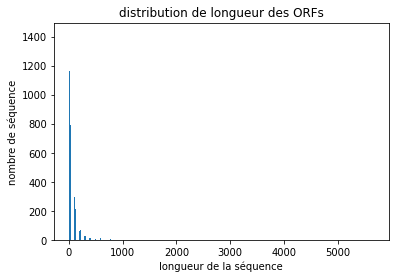

In [67]:
# Question 2
 
# On a remarqué que la plupart des ORFs sont de taille très petite (proche de 0)
    
# Plot avec matplotlib
import matplotlib.pyplot as plt
from collections import Counter
longueurs = [len(seq) for seq in liste_seqs]
ct = Counter(longueurs)
x = [k for (k,v) in ct.items()]
y = [ct[k] for k in x]
plt.xlabel("longueur de la séquence")
plt.ylabel("nombre de séquence")
plt.title("distribution de longueur des ORFs")
plt.bar(x, y)
plt.show()


<b>Question 3)</b> Utilisez la question précédente pour fixer un seuil pour dire qu’un ORF est un gène. (par exemple plus que 500 nucléotides). En déduire une première annotation des gènes dans le génome de _Escherichia coli_. Vous produirez un fichier tab avec les positions de tous les ORFs annotés. 

In [ ]:
# Question 3
# Fichier d'annotation des ORFs

####
#test
# genome2 = genome[:1000]
# genome2 = genome[:10000]
# genome2 = genome[:100000]
# genome2 = genome[:1000000]
genome2 = genome
####

def annotationOrfs(genome, outputFile, seuilOrf, orfs):
    """
    Produire une annotation des gènes d'un génome à partir de l'ensemble des orfs
    entrée : genome sequences
    entrée : seuilOrf - seuil pour dire qu’un ORF est un gène
    entrée : orfs - ensemble des orfs detecté par la fonction liste_orfs
    entrée : outputFile - nom du fichier pour sauvegarder l'annotation
    sortie : None
    """
    def find_orf_genome(valide_orf, genome):
        index_orfs = []
        sub_pos = 0
        last_len = 0
        last_fin = 0
        for orf in valide_orfs:
            sub_pos = (genome[last_fin:]).find(orf)
            if(sub_pos != -1):
                last_len = len(orf)
                index_orfs.append(sub_pos+last_fin)
                last_fin += last_len + sub_pos
        return index_orfs
    valide_orfs = [orf for orf in orfs if len(orf) >= seuilOrf]
    len_orfs = [len(orf) for orf in valide_orfs]
    index_start_orfs_1 = find_orf_genome(valide_orfs, genome)
    index_start_orfs_2 = find_orf_genome(valide_orfs, reversecompl(genome))
    assert(len(index_start_orfs_2) > 0)
    with open(outputFile, "w") as of:
        of.write('number,start,end,strand,length\n')
        count = 0
        virgule = ","
        try:
            for i in range(len(valide_orfs)):
                if index_start_orfs_1[i] != -1:
                    count += 1
                    number = str(count)
                    start_pos = str(index_start_orfs_1[i])
                    len_orf = str(len_orfs[i])
                    stop_pos = str(index_start_orfs_1[i] + len_orfs[i] - 1)
                    strand = "+"
                    # slice_seq = genome[index_start_orfs_1[i]:index_start_orfs_1[i]+10]
                    # slice_seq=""
                    of.write(number + virgule + start_pos + virgule + stop_pos + virgule + strand + virgule + len_orf +"\n")
                    # of.write(number + virgule + start_pos + virgule + stop_pos + virgule + strand + virgule + len_orf + virgule + slice_seq +"\n")
                # if index_start_orfs_2[i] != -1:
                #     count += 1
                #     number = str(count)
                #     start_pos = str(index_start_orfs_2[i])
                #     len_orf = str(len_orfs[i])
                #     stop_pos = str(index_start_orfs_2[i] + len_orfs[i] - 1)
                #     strand = "-"
                #     slice_seq = genome[index_start_orfs_2[i]:index_start_orfs_2[i]+10]
                #     # slice_seq=""
                #     of.write(number + virgule + start_pos + virgule + stop_pos + virgule + strand + virgule + len_orf + virgule + slice_seq + "\n")
            # for i in range(len(valide_orfs)):
            #     if index_start_orfs_2[i] != -1:
            #         count += 1
            #         number = str(count)
            #         start_pos = str(index_start_orfs_2[i])
            #         len_orf = str(len_orfs[i])
            #         stop_pos = str(index_start_orfs_2[i] + len_orfs[i] - 1)
            #         strand = "-"
            #         slice_seq = genome[index_start_orfs_2[i]:index_start_orfs_2[i]+10]
            #         # slice_seq=""
            #         of.write(number + virgule + start_pos + virgule + stop_pos + virgule + strand + virgule + len_orf + virgule + slice_seq + "\n")
        except IndexError:
            pass
liste_seqs2 = __liste_orfs(genome2)
orfs = liste_seqs2
annotationOrfs(genome2, './annotation_des_orfs.csv', 500, orfs)


In [29]:
head('annotation_des_orfs.csv')

number,start,end,strand,length
1,293,2797,+,2505
2,3732,5018,+,1287
3,12101,13963,+,1863
4,14022,15182,+,1161
5,16831,18324,+,1494
6,18418,19698,+,1281
7,19950,21116,+,1167
8,30602,33418,+,2817
9,37843,38973,+,1131
